In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [3]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

In [4]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [5]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [6]:
nfs = [8,16,32,64,64]

In [7]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [8]:
%time run.fit(2, learn)

train: [1.768248125, tensor(0.4032, device='cuda:0')]
valid: [0.3613622314453125, tensor(0.8944, device='cuda:0')]
train: [0.25451984375, tensor(0.9232, device='cuda:0')]
valid: [0.15081968994140624, tensor(0.9545, device='cuda:0')]
CPU times: user 3.77 s, sys: 1.58 s, total: 5.35 s
Wall time: 17 s


### Custom

Let's start by building our own `BatchNorm` layer from scratch.

In [9]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
#         so we have batch norm paramaters for each filter
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
#         register buffer creates self.means and self.vars and gives us benefits like automatically on gpu
# also causes these items to be saved when we save the model which we need since this is part of the model. need them at inference time
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
#         print("x!!", x.shape)
#         example result:
#             x!! torch.Size([512, 8, 14, 14])
#             x!! torch.Size([512, 16, 7, 7])
#             x!! torch.Size([512, 32, 4, 4])
#             x!! torch.Size([512, 64, 2, 2])
#             x!! torch.Size([512, 64, 1, 1])
#             x!! torch.Size([512, 8, 14, 14])
#             x!! torch.Size([512, 16, 7, 7])
#             x!! torch.Size([512, 32, 4, 4])
#             x!! torch.Size([512, 64, 2, 2])
#             x!! torch.Size([512, 64, 1, 1])
#         we average over all of the batches and the length and width of the parameters so we are left with a mean for each filter (the 1 indexed item in x)
# keep dim=True means it will leave a 0 in the index for each of 0 and 2 and 3 so will broadcast nicely
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
#             if we're training we update the mean and the variation like normal
            with torch.no_grad(): m,v = self.update_stats(x)
#         if we're in inference mode we take the weighted moving average of the mean and variation
        else: m,v = self.means,self.vars
#         the normalization is just our value minus the mean divided by the standard variation (square root of the variance)
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [10]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [11]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [12]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.28079935546875, tensor(0.9117, device='cuda:0')]
valid: [0.124269677734375, tensor(0.9642, device='cuda:0')]


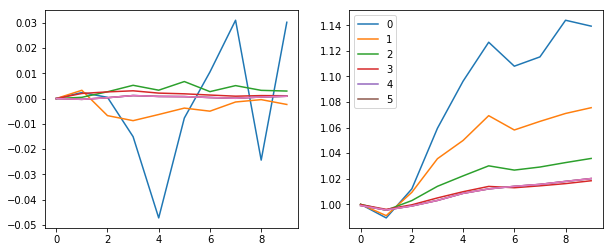

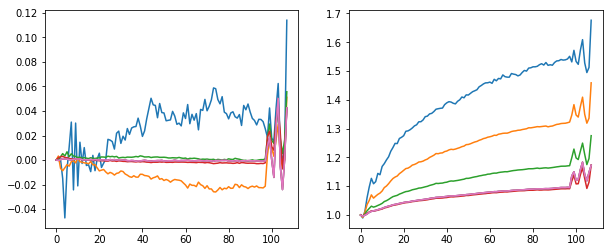

In [13]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [14]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [15]:
%time run.fit(3, learn)

train: [0.27602759765625, tensor(0.9148, device='cuda:0')]
valid: [0.1786552490234375, tensor(0.9439, device='cuda:0')]
train: [0.0937239453125, tensor(0.9704, device='cuda:0')]
valid: [0.113109423828125, tensor(0.9649, device='cuda:0')]
train: [0.06871248046875, tensor(0.9787, device='cuda:0')]
valid: [0.07223031616210937, tensor(0.9784, device='cuda:0')]
CPU times: user 4.03 s, sys: 496 ms, total: 4.52 s
Wall time: 4.54 s


### Builtin batchnorm

In [16]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [17]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [18]:
%time run.fit(3, learn)

train: [0.28875259765625, tensor(0.9129, device='cuda:0')]
valid: [0.11767066650390624, tensor(0.9637, device='cuda:0')]
train: [0.0749825634765625, tensor(0.9764, device='cuda:0')]
valid: [0.08199794921875, tensor(0.9757, device='cuda:0')]
train: [0.0508402392578125, tensor(0.9845, device='cuda:0')]
valid: [0.07347352905273437, tensor(0.9779, device='cuda:0')]
CPU times: user 3.33 s, sys: 604 ms, total: 3.93 s
Wall time: 3.98 s


### With scheduler

Now let's add the usual warm-up/annealing.

Can go up to a learning rate as high as 2 since using batch norm

In [19]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [20]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [21]:
run.fit(8, learn)

train: [0.30782044921875, tensor(0.9081, device='cuda:0')]
valid: [0.119206640625, tensor(0.9614, device='cuda:0')]
train: [0.0955680078125, tensor(0.9703, device='cuda:0')]
valid: [0.10755780029296876, tensor(0.9685, device='cuda:0')]
train: [0.0605357373046875, tensor(0.9803, device='cuda:0')]
valid: [0.0718800537109375, tensor(0.9779, device='cuda:0')]
train: [0.0384215673828125, tensor(0.9878, device='cuda:0')]
valid: [0.0665466064453125, tensor(0.9794, device='cuda:0')]
train: [0.02464458251953125, tensor(0.9921, device='cuda:0')]
valid: [0.046663726806640625, tensor(0.9862, device='cuda:0')]
train: [0.0163460791015625, tensor(0.9954, device='cuda:0')]
valid: [0.04146202697753906, tensor(0.9877, device='cuda:0')]
train: [0.010099387817382812, tensor(0.9977, device='cuda:0')]
valid: [0.03948231506347656, tensor(0.9879, device='cuda:0')]
train: [0.006879940795898438, tensor(0.9986, device='cuda:0')]
valid: [0.03834141540527344, tensor(0.9890, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

In [22]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
#         note, the difference is we are doing 1,2,3 rather than 0,2,3
        m = x.mean((1,2,3), keepdim=True)
        v = x.std ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [23]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [24]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [25]:
%time run.fit(3, learn)

train: [nan, tensor(0.1216, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.33 s, sys: 700 ms, total: 5.03 s
Wall time: 5.06 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

In [ ]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
#         the difference here is doing 2,3 versus 0,2,3 with regular batch norm or 1,2,3 with layer norm
        m = x.mean((2,3), keepdim=True)
        v = x.std ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [ ]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [ ]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 4.46 s, sys: 718 ms, total: 5.18 s
Wall time: 5.18 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](images/norms.png)

### Group norm

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

Let's see how this works by creating a databunch with a batch size of 2

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [ ]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [2.35619296875, tensor(0.1649, device='cuda:0')]
valid: [2867.7198, tensor(0.2604, device='cuda:0')]
CPU times: user 1min 32s, sys: 835 ms, total: 1min 33s
Wall time: 1min 33s


### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [ ]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [ ]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [ ]:
%time run.fit(1, learn)

train: [0.157932021484375, tensor(0.9511, device='cuda:0')]
valid: [0.0986408935546875, tensor(0.9730, device='cuda:0')]
CPU times: user 16.5 s, sys: 1.57 s, total: 18.1 s
Wall time: 18.1 s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

In [ ]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [ ]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [ ]:
%time run.fit(1, learn)

train: [0.1573110546875, tensor(0.9521, device='cuda:0')]
valid: [0.09242745971679688, tensor(0.9818, device='cuda:0')]
CPU times: user 16.6 s, sys: 1.52 s, total: 18.1 s
Wall time: 18.2 s


## Export

In [ ]:
nb_auto_export()

<IPython.core.display.Javascript object>